In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import TransformerMixin
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
data_path = '../data/uci_data.xls'

In [3]:
df = pd.read_excel(data_path, header=0, index_col=0, skiprows=1)
df = df.rename(columns={'PAY_0': 'PAY_1'})

In [4]:
# I set all invalid values to 'other'
df.loc[~(df['EDUCATION'].isin([1, 2, 3, 4])), 'EDUCATION'] = 4
df.loc[~(df['MARRIAGE'].isin([1, 2, 3])), 'MARRIAGE'] = 3

# PAY_* fuera de rango
paux = ~(df['PAY_1'].isin([-1,0,1,2,3,4,5,6,7,8,9]))
for i in range(2, 7):
    paux = paux | ~(df['PAY_' + str(i)].isin([-1,0,1,2,3,4,5,6,7,8,9]))
    
df = df[~paux]

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train.drop(columns=('default payment next month'))
y_train = train[['default payment next month']]
X_test = test.drop(columns=('default payment next month'))
y_test = test[['default payment next month']]

In [6]:
numeric_features = ["LIMIT_BAL", "AGE", 
                    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", 
                    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]

categorical_features = ["SEX", "EDUCATION", "MARRIAGE", "PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

## Modelo 1: LDA

In [54]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearDiscriminantAnalysis(solver='svd'))])

In [55]:
%%time
clf.fit(X_train, y_train.values.ravel());

CPU times: user 518 ms, sys: 33 ms, total: 551 ms
Wall time: 275 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse

In [58]:
print(metrics.classification_report(y_train, clf.predict(X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.85      0.94      0.89     14480
     default       0.67      0.44      0.53      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.69      0.71     18751
weighted avg       0.81      0.82      0.81     18751



### Hyperparameter Search

In [89]:
param_grid = {
    'classifier__tol': [1.0e-5, 1.0e-4, 1.0e-3, 1.03-2]
}

model_lr = model_selection.GridSearchCV(clf, param_grid=param_grid, cv=5)

In [90]:
%%time
model_lr = model_lr.fit(X_train, y_train.values.ravel())

CPU times: user 2.85 s, sys: 2.01 s, total: 4.86 s
Wall time: 1.28 s


In [91]:
model_lr.best_params_

{'classifier__tol': 1e-05}

In [92]:
print(metrics.classification_report(y_train, model_lr.predict(X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89     14480
     default       0.68      0.36      0.48      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.66      0.68     18751
weighted avg       0.80      0.82      0.79     18751



In [93]:
print(metrics.classification_report(y_test, model_lr.predict(X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.83      0.95      0.89      3574
     default       0.71      0.36      0.48      1114

    accuracy                           0.81      4688
   macro avg       0.77      0.66      0.68      4688
weighted avg       0.80      0.81      0.79      4688



In [94]:
from sklearn.feature_selection import RFE

In [116]:
selector = RFE(LinearDiscriminantAnalysis(solver='svd'), n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train.values.ravel())

In [124]:
for i,n in zip(range(X_train.shape[1]), X_train.columns):
    print('Column: %s, Selected %s, Rank: %.3f' % (n, selector.support_[i], selector.ranking_[i]))

Column: LIMIT_BAL, Selected False, Rank: 16.000
Column: SEX, Selected False, Rank: 7.000
Column: EDUCATION, Selected False, Rank: 9.000
Column: MARRIAGE, Selected False, Rank: 4.000
Column: AGE, Selected False, Rank: 10.000
Column: PAY_1, Selected True, Rank: 1.000
Column: PAY_2, Selected False, Rank: 5.000
Column: PAY_3, Selected False, Rank: 3.000
Column: PAY_4, Selected False, Rank: 8.000
Column: PAY_5, Selected False, Rank: 2.000
Column: PAY_6, Selected False, Rank: 6.000
Column: BILL_AMT1, Selected False, Rank: 12.000
Column: BILL_AMT2, Selected False, Rank: 14.000
Column: BILL_AMT3, Selected False, Rank: 20.000
Column: BILL_AMT4, Selected False, Rank: 18.000
Column: BILL_AMT5, Selected False, Rank: 17.000
Column: BILL_AMT6, Selected False, Rank: 22.000
Column: PAY_AMT1, Selected False, Rank: 11.000
Column: PAY_AMT2, Selected False, Rank: 13.000
Column: PAY_AMT3, Selected False, Rank: 23.000
Column: PAY_AMT4, Selected False, Rank: 19.000
Column: PAY_AMT5, Selected False, Rank: 21.

## Modelo 2: AdaBoost

In [130]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', AdaBoostClassifier())])

clf.fit(X_train, y_train.values.ravel());

In [131]:
print(metrics.classification_report(y_train, clf.predict(X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89     14480
     default       0.69      0.40      0.50      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.67      0.70     18751
weighted avg       0.81      0.82      0.80     18751



In [132]:
print(metrics.classification_report(y_test, clf.predict(X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.83      0.95      0.89      3574
     default       0.70      0.39      0.50      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.67      0.69      4688
weighted avg       0.80      0.82      0.79      4688



### Hyperparameter Search

In [133]:
param_grid = {
    'classifier__n_estimators': [30, 40, 50, 60, 70, 80],
    'classifier__learning_rate': [0.3, 0.6, 1, 1.3, 1.6]
}

model_lr = model_selection.GridSearchCV(clf, param_grid=param_grid, cv=5)

In [134]:
%%time
model_lr = model_lr.fit(X_train, y_train.values.ravel())

CPU times: user 4min 3s, sys: 95 ms, total: 4min 3s
Wall time: 4min 3s


In [135]:
model_lr.best_params_

{'classifier__learning_rate': 1.3, 'classifier__n_estimators': 60}

In [136]:
print(metrics.classification_report(y_train, model_lr.predict(X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.85      0.94      0.89     14480
     default       0.67      0.42      0.51      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.68      0.70     18751
weighted avg       0.81      0.82      0.80     18751



In [137]:
print(metrics.classification_report(y_test, model_lr.predict(X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.71      0.40      0.51      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.68      0.70      4688
weighted avg       0.81      0.82      0.80      4688



In [141]:
selector = RFE(AdaBoostClassifier(), n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train.values.ravel())

In [142]:
for i,n in zip(range(X_train.shape[1]), X_train.columns):
    print('Column: %s, Selected %s, Rank: %.3f' % (n, selector.support_[i], selector.ranking_[i]))

Column: LIMIT_BAL, Selected False, Rank: 5.000
Column: SEX, Selected False, Rank: 22.000
Column: EDUCATION, Selected False, Rank: 20.000
Column: MARRIAGE, Selected False, Rank: 18.000
Column: AGE, Selected False, Rank: 21.000
Column: PAY_1, Selected False, Rank: 3.000
Column: PAY_2, Selected False, Rank: 11.000
Column: PAY_3, Selected False, Rank: 23.000
Column: PAY_4, Selected False, Rank: 17.000
Column: PAY_5, Selected False, Rank: 15.000
Column: PAY_6, Selected False, Rank: 16.000
Column: BILL_AMT1, Selected True, Rank: 1.000
Column: BILL_AMT2, Selected False, Rank: 14.000
Column: BILL_AMT3, Selected False, Rank: 10.000
Column: BILL_AMT4, Selected False, Rank: 8.000
Column: BILL_AMT5, Selected False, Rank: 19.000
Column: BILL_AMT6, Selected False, Rank: 6.000
Column: PAY_AMT1, Selected False, Rank: 13.000
Column: PAY_AMT2, Selected False, Rank: 2.000
Column: PAY_AMT3, Selected False, Rank: 9.000
Column: PAY_AMT4, Selected False, Rank: 4.000
Column: PAY_AMT5, Selected False, Rank: 7.

## Model 3: RC

In [144]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RidgeClassifier())])

clf.fit(X_train, y_train.values.ravel());

In [145]:
print(metrics.classification_report(y_train, clf.predict(X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.85      0.94      0.89     14480
     default       0.68      0.42      0.52      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.68      0.71     18751
weighted avg       0.81      0.82      0.81     18751



In [146]:
print(metrics.classification_report(y_test, clf.predict(X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.71      0.41      0.52      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.68      0.71      4688
weighted avg       0.81      0.82      0.80      4688



### Hyperparameter Search

In [147]:
param_grid = {
    'classifier__alpha': [0.1, 0.5, 1, 1.3, 1.6]
}

model_lr = model_selection.GridSearchCV(clf, param_grid=param_grid, cv=5)
model_lr = model_lr.fit(X_train, y_train.values.ravel())

In [148]:
model_lr.best_params_

{'classifier__alpha': 0.5}

In [149]:
print(metrics.classification_report(y_train, model_lr.predict(X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.85      0.94      0.89     14480
     default       0.68      0.42      0.52      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.68      0.71     18751
weighted avg       0.81      0.82      0.81     18751



In [150]:
print(metrics.classification_report(y_test, model_lr.predict(X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.71      0.41      0.52      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.68      0.71      4688
weighted avg       0.81      0.82      0.80      4688



In [153]:
selector = RFE(RidgeClassifier(), n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train.values.ravel())

In [154]:
for i,n in zip(range(X_train.shape[1]), X_train.columns):
    print('Column: %s, Selected %s, Rank: %.3f' % (n, selector.support_[i], selector.ranking_[i]))

Column: LIMIT_BAL, Selected False, Rank: 16.000
Column: SEX, Selected False, Rank: 7.000
Column: EDUCATION, Selected False, Rank: 9.000
Column: MARRIAGE, Selected False, Rank: 4.000
Column: AGE, Selected False, Rank: 10.000
Column: PAY_1, Selected True, Rank: 1.000
Column: PAY_2, Selected False, Rank: 5.000
Column: PAY_3, Selected False, Rank: 3.000
Column: PAY_4, Selected False, Rank: 8.000
Column: PAY_5, Selected False, Rank: 2.000
Column: PAY_6, Selected False, Rank: 6.000
Column: BILL_AMT1, Selected False, Rank: 12.000
Column: BILL_AMT2, Selected False, Rank: 14.000
Column: BILL_AMT3, Selected False, Rank: 20.000
Column: BILL_AMT4, Selected False, Rank: 18.000
Column: BILL_AMT5, Selected False, Rank: 17.000
Column: BILL_AMT6, Selected False, Rank: 22.000
Column: PAY_AMT1, Selected False, Rank: 11.000
Column: PAY_AMT2, Selected False, Rank: 13.000
Column: PAY_AMT3, Selected False, Rank: 23.000
Column: PAY_AMT4, Selected False, Rank: 19.000
Column: PAY_AMT5, Selected False, Rank: 21.

## Model 4: Random Forest

In [157]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

clf.fit(X_train, y_train.values.ravel());

In [158]:
print(metrics.classification_report(y_train, clf.predict(X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       1.00      1.00      1.00     14480
     default       1.00      1.00      1.00      4271

    accuracy                           1.00     18751
   macro avg       1.00      1.00      1.00     18751
weighted avg       1.00      1.00      1.00     18751



In [159]:
print(metrics.classification_report(y_test, clf.predict(X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.70      0.40      0.51      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.67      0.70      4688
weighted avg       0.80      0.82      0.80      4688



### Hyperparameter search

In [160]:
%%time
param_grid = {
    'classifier__n_estimators': [30, 60, 100, 130, 150],
    'classifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'classifier__criterion': ['gini', 'entropy']
}

model_lr = model_selection.GridSearchCV(clf, param_grid=param_grid, cv=5)
model_lr = model_lr.fit(X_train, y_train.values.ravel())

In [161]:
model_lr.best_params_

{'classifier__criterion': 'entropy',
 'classifier__min_samples_leaf': 4,
 'classifier__n_estimators': 60}

In [162]:
print(metrics.classification_report(y_train, model_lr.predict(X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.89      0.98      0.93     14480
     default       0.90      0.57      0.70      4271

    accuracy                           0.89     18751
   macro avg       0.89      0.78      0.82     18751
weighted avg       0.89      0.89      0.88     18751



In [163]:
print(metrics.classification_report(y_test, clf.predict(X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.70      0.40      0.51      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.67      0.70      4688
weighted avg       0.80      0.82      0.80      4688



In [164]:
selector = RFE(RandomForestClassifier(), n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train.values.ravel())

In [165]:
for i,n in zip(range(X_train.shape[1]), X_train.columns):
    print('Column: %s, Selected %s, Rank: %.3f' % (n, selector.support_[i], selector.ranking_[i]))

Column: LIMIT_BAL, Selected False, Rank: 16.000
Column: SEX, Selected False, Rank: 23.000
Column: EDUCATION, Selected False, Rank: 21.000
Column: MARRIAGE, Selected False, Rank: 22.000
Column: AGE, Selected False, Rank: 12.000
Column: PAY_1, Selected False, Rank: 4.000
Column: PAY_2, Selected False, Rank: 13.000
Column: PAY_3, Selected False, Rank: 17.000
Column: PAY_4, Selected False, Rank: 19.000
Column: PAY_5, Selected False, Rank: 18.000
Column: PAY_6, Selected False, Rank: 20.000
Column: BILL_AMT1, Selected True, Rank: 1.000
Column: BILL_AMT2, Selected False, Rank: 9.000
Column: BILL_AMT3, Selected False, Rank: 3.000
Column: BILL_AMT4, Selected False, Rank: 6.000
Column: BILL_AMT5, Selected False, Rank: 2.000
Column: BILL_AMT6, Selected False, Rank: 5.000
Column: PAY_AMT1, Selected False, Rank: 7.000
Column: PAY_AMT2, Selected False, Rank: 8.000
Column: PAY_AMT3, Selected False, Rank: 10.000
Column: PAY_AMT4, Selected False, Rank: 11.000
Column: PAY_AMT5, Selected False, Rank: 15.

In [183]:
fi = model_lr.estimator['classifier'].feature_importances_
var_names = list(model_lr.best_estimator_['preprocessor']._iter(fitted=True))[1][1].get_feature_names(['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'PAY_1', 'PAY_2',
                                                   'PAY_3', 'PAY_4', 'PAY_5',
                                                   'PAY_6'])

In [186]:
forest_importances = pd.Series(fi, index=numeric_features + list(var_names))

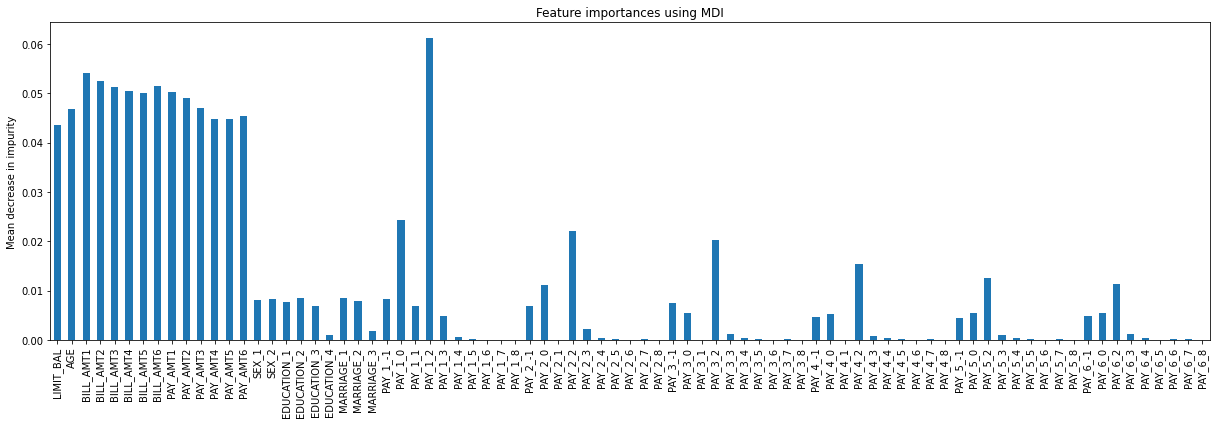

In [191]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(17, 6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()